In [315]:
import cupy as cp
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
import timeit
from skimage.color import rgb2hsv,hsv2rgb
import concurrent.futures
import copy
import os
import natsort
import xlwt
import datetime


In [316]:
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [317]:
one = cp.ones((256,256))
height = width = 256

In [318]:
frame1 = '/content/gdrive/MyDrive/auv_files/test_images/rod1.jpg'
print(frame1)

/content/gdrive/MyDrive/auv_files/test_images/rod1.jpg


In [319]:


def  HSVStretching(sceneRadiance):
    
    sceneRadiance = cp.uint8(sceneRadiance)
    img_hsv = rgb2hsv(sceneRadiance)
    img_hsv = cp.array(img_hsv)
    labArray = global_stretching(img_hsv,height, width)
    labArray= cp.asnumpy(labArray)
    img_rgb = hsv2rgb(labArray) * 255
    #print(img_rgb)

    return img_rgb

In [320]:
def global_stretching(img_L,height, width):
    
    I_min = cp.min(img_L)
    I_max = cp.max(img_L)
    I_mean = cp.mean(img_L)
    I_min1 = (cp.ones((256,256,3)) *I_min).astype(int)
    I_max1 = (cp.ones((256,256,3)) *I_max).astype(int)
    pout = (img_L -I_min1) /(I_max1 - I_min1)
    #print(pout)
    return pout



In [321]:


 
def stretching(img):
    with concurrent.futures.ThreadPoolExecutor() as executor:

      input=cp.swapaxes(cp.array(img),0,2)
      inp=[0,1,2]
      h=[height,height,height]
      w=[width,width,width]
      results=executor.map(histogram_general,input,h,w,inp)
      i=0
      for result in results:
        print(type(result))
        input[i]=result
        i=i+1
    return img

def RGB_equalisation(img):

    img = cp.float32(img)
    avg_RGB = cp.mean(img, axis=tuple(range(img.ndim-1)))

    a_r = avg_RGB[0]/avg_RGB[2]
    a_g =  avg_RGB[0]/avg_RGB[1]
    ratio = [1,a_g,a_r]
    img1 = img*ratio
    img1 = cp.clip(img1, 0, 255)
   
    return img1

In [322]:


def histogram_general(r_array,height, width,input):
    
    length = height * width
    r_array=cp.array(r_array)
    R_rray=r_array.flatten()
    R_rray.sort()
    I_min = int(R_rray[int(length / 500)])
    I_max = int(R_rray[-int(length / 500)])
    zero = (one *0).astype(int)
    maxi = (one *255).astype(int)

    I_max1 = (one *I_max).astype(int)
    I_min1 = (one *I_min).astype(int) 
    p_out0 = ((r_array - I_min1) * ((255 - I_min1) / (I_max1 - I_min1)))+ I_min1
    p_out1 = ((r_array - I_min1) * ((255) / (I_max1 - I_min1)))
    p_out2 = ((r_array - I_min1) * ((I_max1) / (I_max1 - I_min1)))

    if input == 0:
        c = cp.where(r_array < I_min1, I_min , p_out0)
        c = cp.where(r_array > I_max1, maxi, c)
    elif input == 1:
        c = cp.where(r_array < I_min1, zero, p_out1)
        c = cp.where(r_array > I_max1, maxi, c)
    elif input == 2 :
        c = cp.where(r_array < I_min1, zero, p_out2)
        c = cp.where(r_array > I_max1, I_max, c)
    return c
  
    



<class 'cupy.core.core.ndarray'>
<class 'cupy.core.core.ndarray'>
<class 'cupy.core.core.ndarray'>
Time per image  0.07895966399996723 0


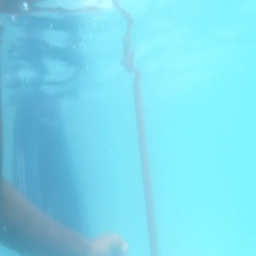

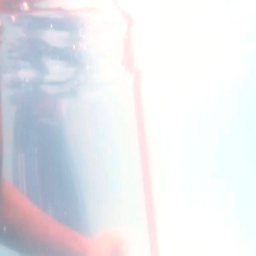

In [323]:
if __name__ == '__main__':
    pass
count = 0
import timeit
starti = timeit.default_timer()
frame = cv2.imread(frame1)
frame = cv2.resize(frame , (256,256))
sceneRadiance = RGB_equalisation(frame)
sceneRadiance = stretching(sceneRadiance)
sceneRadiance = HSVStretching(sceneRadiance)
stopi = timeit.default_timer()
print('Time per image ', stopi - starti ,count)
cv2_imshow(frame)
cv2_imshow(sceneRadiance)
